In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

# K Nearest Neighbors Classifiers

So far we've covered learning via probability (naive Bayes) and learning via errors (regression). Here we'll cover learning via similarity. This means we look for the datapoints that are most similar to the observation we are trying to predict.

Let's start by the simplest example: **Nearest Neighbor**.

## Nearest Neighbor

Let's use this example: classifying a song as either "rock" or "jazz". For this data we have measures of duration in seconds and loudness in loudness units (we're not going to be using decibels since that isn't a linear measure, which would create some problems we'll get into later).

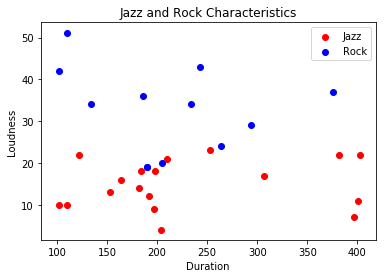

In [2]:
music = pd.DataFrame()

# Some data to play with.
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]

# We know whether the songs in our training data are jazz or not.
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]


# Look at our data.
plt.scatter(
    music[music['jazz'] == 1].duration,
    music[music['jazz'] == 1].loudness,
    color='red'
)
plt.scatter(
    music[music['jazz'] == 0].duration,
    music[music['jazz'] == 0].loudness,
    color='blue'
)
plt.legend(['Jazz', 'Rock'])
plt.title('Jazz and Rock Characteristics')
plt.xlabel('Duration')
plt.ylabel('Loudness')
plt.show()

The simplest form of a similarity model is the **Nearest Neighbor model**. This works quite simply: when trying to predict an observation, we find the closest (or _nearest_) known observation in our training data and use that value to make our prediction. Here we'll use the model as a classifier, the outcome of interest will be a category.

To find which observation is "nearest" we need some kind of way to measure distance. Typically we use _Euclidean distance_, the standard distance measure that you're familiar with from geometry. With one observation in n-dimensions $(x_1, x_2, ...,x_n)$ and the other $(w_1, w_2,...,w_n)$:

$$ \sqrt{(x_1-w_1)^2 + (x_2-w_2)^2+...+(x_n-w_n)^2} $$

You might recognize this formula, (taking distances, squaring them, adding the squares together, and taking the root) as a generalization of the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem) into n-dimensions. You can technically define any distance measure you want, and there are times where this customization may be valuable. As a general standard, however, we'll use Euclidean distance.

**Now that we have a distance measure from each point in our training data to the point we're trying to predict the model can find the datapoint with the smallest distance and then apply that category to our prediction.**

Let's try running this model, using the SKLearn package.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a song with 24 loudness that's 190 seconds long.
neighbors.predict([[24, 190]])

array([0])

Looks like our model is predicting that 24 loudness, 190 second long song is _not_ jazz, aka it's rock. All it takes to train the model is a dataframe of independent variables and a dataframe of dependent outcomes.

Nearest Neighbor is a simplification of K-Nearest Neighbors. The jump, however, isn't that far.

## K-Nearest Neighbors

**K-Nearest Neighbors** (or "**KNN**") is the logical extension of Nearest Neighbor. Instead of looking at just the single nearest datapoint to predict an outcome, _we look at several of the nearest neighbors, with $k$ representing the number of neighbors we choose to look at._ Each of the $k$ neighbors gets to vote on what the predicted outcome should be.

This does a couple of valuable things. Firstly, it smooths out the predictions. If only one neighbor gets to influence the outcome, the model explicitly overfits to the training data. Any single outlier can create pockets of one category prediction surrounded by a sea of the other category.

**This also means instead of just predicting classes, we get implicit probabilities.** If each of the $k$ neighbors gets a vote on the outcome, then the probability of the test example being from any given class $i$ is:
$$ \frac{votes_i}{k} $$

And this applies for all classes present in the training set. Our example only has two classes, but this model can accommodate as many classes as the data set necessitates. To come up with a classifier prediction it simply takes the class for which that fraction is maximized.

Let's expand our initial nearest neighbors model from above to a KNN with a $k$ of 5.

In [4]:
neighbors = KNeighborsClassifier(n_neighbors=5)
X = music[['loudness', 'duration']]
Y = music.jazz
neighbors.fit(X,Y)

## Predict for a 24 loudness, 190 seconds long song.
print(neighbors.predict([[24, 190]]))
print(neighbors.predict_proba([[24, 190]]))

[1]
[[ 0.4  0.6]]


Now our test prediction has changed. In using the five nearest neighbors it appears that there were two votes for rock (2/5 = 0.4) and three for jazz (3/5 = 0.6), so it was classified as a jazz song. This is different than our simpler Nearest Neighbors model. While the closest observation was in fact rock, there are more jazz songs in the nearest $k$ neighbors than rock.

We can visualize our decision bounds with something called a _mesh_. This allows us to generate a prediction over the whole space. Read the code below and make sure you can pull out what the individual lines do, consulting the documentation for unfamiliar methods if necessary.

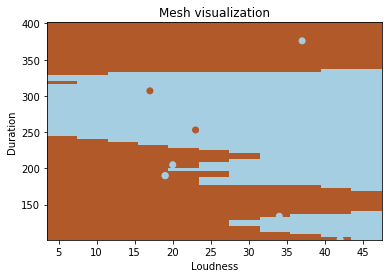

In [5]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 4.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

Looking at the visualization above, any new point that fell within a blue area would be predicted to be jazz, and any point that fell within a brown area would be predicted to be rock.

The boundaries above are strangly jagged here, and we'll get into that in more detail in the next lesson.

Also note that the visualization isn't completely continuous. There are an infinite number of points in this space, and we can't calculate the value for each one. That's where the mesh comes in. We set our mesh size (`h = 4.0`) to 4.0 above, which means we calculate the value for each point in a grid where the points are spaced 4.0 away from each other.

You can make the mesh size smaller to get a more continuous visualization, but at the cost of a more computationally demanding calculation.

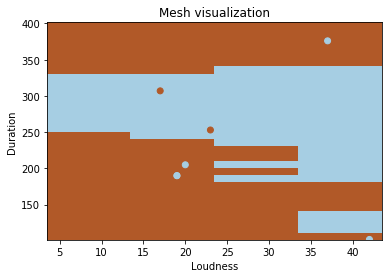

In [6]:
# Mesh size.
h = 10.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

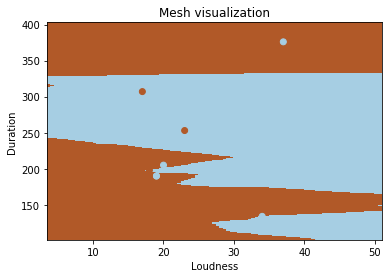

In [7]:
# Mesh size.
h = 0.5

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

## Challenge: Implement the Nearest Neighbor algorithm 

The Nearest Neighbor algorithm is extremely simple. So simple, in fact, that you should be able to build it yourself from scratch using the Python you already know. Code a Nearest Neighbors algorithm that works for two dimensional data.

In [16]:
# Given datapoints

X = music[['loudness', 'duration']]
Y = music.jazz

In [11]:
def music_pred(loudness, duration):
    
    all_dist = []
    
    for n in range(len(X)):
        distance = np.sqrt((X['loudness'][n] - loudness)**2 + (X['duration'][n] - duration)**2)
        all_dist.append(distance)

        point = int(all_dist.index(min(all_dist)))
        
    print('Minimum calculated distance: ', min(all_dist))
    print('Predicted music category: ', Y[point])

In [10]:
n_neighbors = KNeighborsClassifier(n_neighbors=1)
X = music[['loudness', 'duration']]
Y = music.jazz
n_neighbors.fit(X,Y)

## Predict for a song with 24 loudness that's 190 seconds long.
n_neighbors.predict([[19, 200]])

array([1])

In [12]:
music_pred(19,200)

Minimum calculated distance:  2.2360679775
Predicted music category:  1


In [14]:
music_pred(25, 350)

Minimum calculated distance:  28.6356421266
Predicted music category:  0


In [15]:
n_neighbors.predict([[25, 350]])

array([0])

In [17]:
music_pred(35, 175)

Minimum calculated distance:  11.0453610172
Predicted music category:  0


In [18]:
n_neighbors.predict([[35, 175]])

array([0])

# Unit 3.1.2 Tuning KKN - normalizing distance, picking k

## Distance and Normalizing

We've talked about the distance measure we use for deciding how close other observations are to a test point, but when we did so we glossed over some important nuance in measuring distance. Specifically, _the measurement makes the assumption that all units are equal._ So, in our previous example, being 1 loudness unit away is equivalent to being 1 second away. This is intensely problematic and one of the main issues people have with KNN. **Units are rarely equivalent, and discerning how to adjust that unequivalence is an abstract and touchy subject.** This difficulty also makes _binary or categorical variables nearly impossible to include in a KNN model._ It really is best if they are continuous. 

It can be a more obvious challenge if you were dealing with something where the relative scales are strikingly different. For example, if you were looking at buildings and you have height in floors and square footage, you'd have a model that would really only care about square footage since distance in that dimension would be a far greater number of units than the number of floors.

To deal with this, typically data scientists will engage in something called __normalization__. Normalization is a way of taking these seemingly incommensurate measures and making them comparable. There are two main normalization techniques that are effective with KNN.

1. You can set the bounds of the data to 0 and 1, and then **rescale** every variable to be within those bounds (it may also be reasonable to do -1 to 1, but the difference is actually immaterial). This way every data point is measured in terms of its distance between the max and minimum of its category. This is best if the data shows a linear relationship, such that scaling to a 0 to 1 range makes logical sense. It is also best if there are known limits to the dataset, as those make for logical bounds for 0 and 1 for the rescaling.

2. You can also calculate how far each observation is from the mean, expressed in number of standard deviations: this is often called **z-scores.** Calculating z-scores and using them as your basis for measuring distance works for continuous data and puts everything in terms of how far from the mean (or "abnormal") it is.


## Weighting

There is one more thing to address when talking about distance, and that is weighting. In the vanilla version of KNN, all $k$ of the closest observations are given equal votes on what the outcome of our test observation should be. When the data is densely populated that isn't necessarily a problem. Particularly if there is variance in the measurement itself, not trying to draw information from small differences in distance can be wise.

**However, sometimes the $k$ nearest observations are not all similarly close to the test. In that case it may be useful to weight by distance. Functionally this will weight by the inverse of distance, so that closer datapoints (with a low distance) have a higher weight than further ones.**

SKLearn again makes this quite easy to implement. There is an optional weights parameter that can be used when defining the model. Set that parameter to "distance" and you will use distance weighting.

Let's try it below and see how it affects our model. In this example we'll also use the stats module from SciPy to convert our data to z-scores.

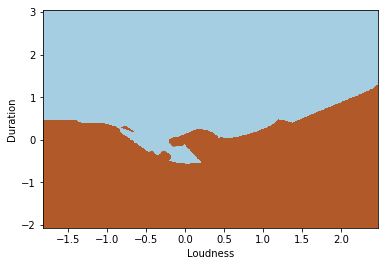

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Our input data frame will be the z-scores this time instead of raw data.
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit our model.
Y = music.jazz
neighbors.fit(X, Y)

# Arrays, not data frames, for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = .01

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

This is a much more nuanced decision boundary, but it's also relatively continuous and consistent, providing a nice sense of which regions are likely to be which classification.


## Choosing K

The last major aspect of tuning KNN is picking $k$. This choice is largely up to the data scientist building the model but there are some things to consider.

Choosing $k$ is a tradeoff. The larger the $k$ the more smoothed out your decision space will be, with more observations getting a vote in the prediction. A smaller $k$ will pick up more subtle deviations, but these deviations could be just randomness and therefore you could just be overfitting. Add in weighting and that's an additional dimension to this entire conversation.

In the end, the best technique is probably to try multiple models and use your validation techniques to see which is best. In particular, k-fold cross validation is a great way to see how your KNN model is performing.


## DRILL:

Let's say we work at a credit card company and we're trying to figure out if people are going to pay their bills on time. We have everyone's purchases, split into four main categories: groceries, dining out, utilities, and entertainment. What are some ways you might use KNN to create this model? What aspects of KNN would be useful? Write up your thoughts in submit a link below.

### Answer

We could use how much people spend in each of the four categories to determine the likelihood that the person will pay their bills on time.  I would calculate the percentage spent in each category each month as a predictor, which would normalize the categories.  KNN makes it possible to consider how spending in these categories affects bill pay.  For exmaple, a person who mostly uses their credit card for entertainment and dining out may be less likely to pay their bills on time than a person who spends more money on groceries and utilities. KNN allows you to consider the four categories of spending, instead of just relying on the total monthly credit bill, as startdards of living varies from person to person.

# Unit 3.1.3 KNN Regression

In [42]:
music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]

# KNN Regression

So far we've introduced KNN as a classifier, meaning it assigns observations to categories or assigns probabilities to the various categories. However, KNN is also a reasonable algorithm for regression. It's a simple extension of what we've learned before and just as easy to implement.

## Everything's the Same

Switching KNN to a regression is a simple process. In our previous models, each of the $k$ oberservations voted for a _category_. As a regression they vote instead for a _value_. Then instead of taking the most popular response, the algorithm averages all of the votes. If you have weights you perform a weighted average.

It's really that simple.

Let's go over a quick example just to confirm your understanding.

Let's stick with the world of music. Instead of trying to classify songs as rock or jazz, lets take the same data with an additional column: beats per minute, or BPM. Can we train our model to predict BPM?

First let's try to predict just in terms of loudness, as this will be easier to represent graphically.

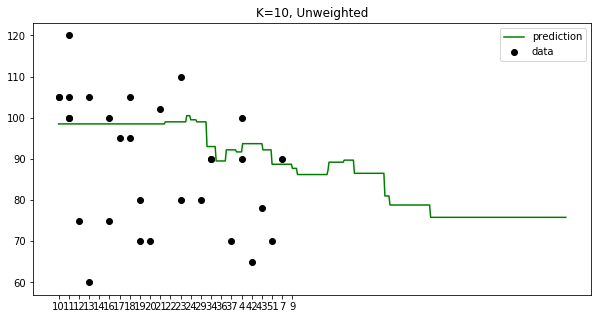

In [32]:
from sklearn import neighbors

#Set up matplotlib
f, ax = plt.subplots(figsize=(10,5))

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

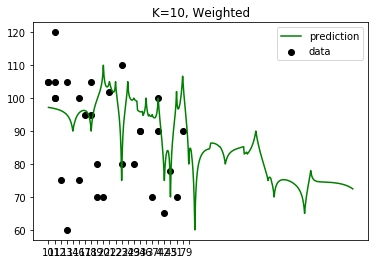

In [33]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

### What does this mean???????

Notice how it seems like the weighted model grossly overfits to points. It is interesting that it oscillates around the datapoints. This is because the decay in weight happens so quickly.


## Validating KNN

Now validating KNN, whether a regression or a classifier, is pretty much exactly the same as evaluating other classifiers or regression. Cross validation is still tremendously valuable. You can do holdouts. You even still get an $R^2$ value for the regression.

Why don't we validate that overfitting of the previous model with some k-fold cross validation? The test statistic given by this model is $R^2$, which measures the same as in linear regression.

In [37]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


First let me state that these two models are fantastically awful. There doesn't seem to be much of a relationship. It's all very poor. However the increased variance in the weighted model is interesting.


#### Assignment
Why don't you add the other feature and mess around with $k$ and weighting to see if you can do any better than we've done so far?

In [59]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music[['loudness', 'duration']])
Y = music.bpm
knn.fit(X, Y)

print(knn.predict([[308, 45]]))

[ 94.]


## Don't know how to test knn model with 2 features.

In [83]:
# Set up our prediction line.
T_loud = np.arange(0, 50, 0.1)[:, np.newaxis]
T_duration = np.arange(0, 500, 1)[:, np.newaxis]

Y_ = knn_w.predict([T_loud, T_duration])

# Relevance of scatterplot when you have 2 independent variables?
# Trailing underscores are a common convention for a prediction.
plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

ValueError: Found array with dim 3. Estimator expected <= 2.